### Clasificación de Noticias Usando RNNs

#### Librerías

In [1]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import re
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

#### 1. Carga y Exploración de Datos

In [2]:
Df = pd.read_excel("C:/Users/USER/OneDrive - universidadean.edu.co/5. NLP/Repositorio NLP/Actividad 2/Noticias.xlsx", engine='openpyxl')
Df.drop('Columna1', axis=1, inplace=True)
Df

,Enlaces,Título,info,contenido,Etiqueta
0,https://www.eltiempo.com/agresion-contra-un-op...,Operador de grúa quedó inconsciente tras agres...,El conductor de una moto le lanzó el casco y p...,Las autoridades están buscando al conductor de...,colombia
1,https://www.eltiempo.com/archivo/documento/CMS...,"Usaquén, primera en infracciones por mal parqueo",La localidad ocupa el primer lugar en comparen...,"""Los andenes son para los peatones"", reclama e...",archivo
2,https://www.eltiempo.com/archivo/documento/CMS...,'Me atracaron y vi un arma que me heló la sang...,Un ciudadano relata cómo cuatro hombres lo rob...,A las 7 de la noche me había quedado de encont...,archivo
3,https://www.eltiempo.com/archivo/documento/CMS...,"Escoltas mal estacionados, dolor de cabeza de ...",Las zonas de restaurantes se convierten en par...,Atravesados. Eso es lo que se les pasa por la ...,archivo
4,https://www.eltiempo.com/archivo/documento/CMS...,Radicado primer proyecto que autorizaría union...,"El representante de 'la U', Miguel Gómez, dijo...",“Estamos proponiendo la figura de un contrato ...,archivo
...,...,...,...,...,...
14391,https://www.eltiempo.com/vida/viajar/una-viaje...,Una viajera pensó que la aerolínea Viva Air le...,La mujer hizo la denuncia en redes. La aerolín...,En Twitter es tendencia 'FCAS' por una denunci...,vida
14392,https://www.eltiempo.com/vida/viajar/un-dia-pe...,"Un día perfecto en Coco Cay, la isla privada d...",El proyecto Global Private Island Collection c...,La naviera internacional Royal Caribbean prese...,vida
14393,https://www.eltiempo.com/vida/viajar/visitar-b...,Barú: el paraíso colombiano abierto para todos...,Cuatro hoteles y el Aviario Nacional lanzarán ...,¿Necesita razones para ir a Barú? A menos de u...,vida
14394,https://www.eltiempo.com/vida/viajar/we-trade-...,"Con WeTrade, llega la hora LGBT a Bogotá",El 1 y 2 de noviembre se celebrará esta Feria ...,Se estima que la población LGTBI en Colombia e...,vida


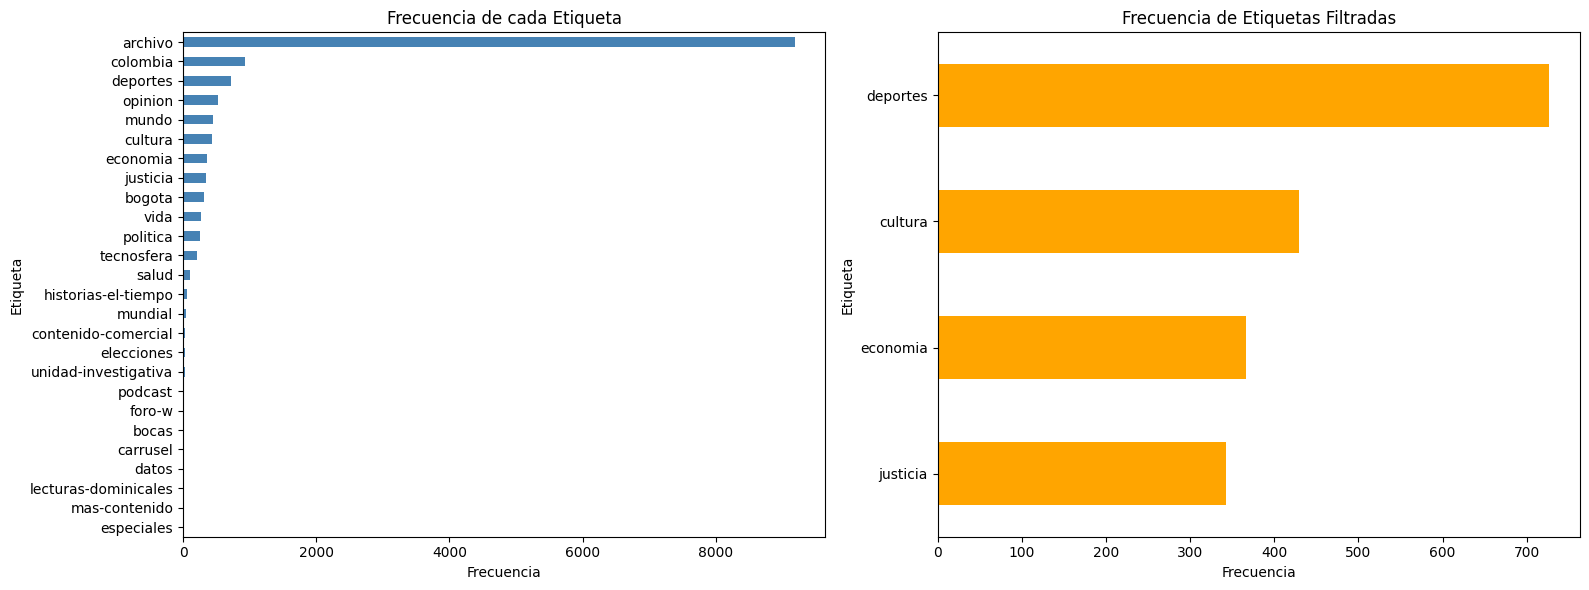

In [3]:
# Calcular las frecuencias
frecuencia_etiquetas = Df['Etiqueta'].value_counts()

# Crear los subgráficos en una sola fila
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 fila, 2 columnas

# Graficar las frecuencias generales
frecuencia_etiquetas.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Frecuencia de cada Etiqueta')
axes[0].set_xlabel('Frecuencia')
axes[0].set_ylabel('Etiqueta')
axes[0].invert_yaxis()  # Invertir el eje Y

# Filtrar etiquetas
Df_filter = Df[Df['Etiqueta'].isin(["deportes", "cultura", "economia", "justicia"])]
frecuencia_etiquetas_filter = Df_filter['Etiqueta'].value_counts()

# Graficar las frecuencias filtradas
frecuencia_etiquetas_filter.plot(kind='barh', ax=axes[1], color='orange')
axes[1].set_title('Frecuencia de Etiquetas Filtradas')
axes[1].set_xlabel('Frecuencia')
axes[1].set_ylabel('Etiqueta')
axes[1].invert_yaxis()  # Invertir el eje Y

# Ajustar diseño para evitar solapamientos
plt.tight_layout()
plt.show()



#### 2. Filtrado de Datos

In [4]:
#Eliminar contenido vacio
Df_filter = Df_filter.dropna(subset=['contenido'])

Df_filter


,Enlaces,Título,info,contenido,Etiqueta
10487,https://www.eltiempo.com/cultura/al-interior-d...,"Al interior de, aparte, roquero, rock / El len...",'Al interior de' es el reemplazo sofisticado e...,Citas: “Los crímenes de violencia sexual comet...,cultura
10488,https://www.eltiempo.com/cultura/arte-y-teatro...,Antonina Canal: 20 años de danza oriental en C...,La bailarina habló con EL TIEMPO de su trayect...,Con motivo de la celebración de los 20 años de...,cultura
10489,https://www.eltiempo.com/cultura/arte-y-teatro...,"Aparece en Holanda cuadro de Picasso, robado h...","La pintura era propiedad de un jeque saudí, Ab...","El cuadro Busto de mujer, del artista español ...",cultura
10490,https://www.eltiempo.com/cultura/arte-y-teatro...,Así será la programación del Carnaval de las A...,El evento con algunos de los artistas más repr...,"El Carnaval de las Artes, organizado en Barran...",cultura
10491,https://www.eltiempo.com/cultura/arte-y-teatro...,‘Fragmentos’ se viste de charlas y música,El lugar donde está el monumento de la artista...,"Louise du Toit, filósofa; el doctor Denis Mukw...",cultura
...,...,...,...,...,...
12467,https://www.eltiempo.com/justicia/servicios/po...,Más de 70 mil policías apoyan jornada de aisla...,Miisterio de Defensa activó dispositivo especi...,"El ministro de la Defensa, Carlos Holmes Truj...",justicia
12468,https://www.eltiempo.com/justicia/servicios/pr...,Habrá proyecto conjunto para superar la crisis...,Se revisarán “conductas antisociales” que se h...,Después de varios contrapunteos sobre la mejor...,justicia
12469,https://www.eltiempo.com/justicia/servicios/qu...,¿Qué hacer en caso de un accidente de tránsito...,EL TIEMPO y la Unilibre responden a esta y otr...,El TIempo y la Universidad Libre se aliaron pa...,justicia
12470,https://www.eltiempo.com/justicia/servicios/su...,Otorgan subsidios a tres obreros del edificio ...,También la esposa de una de las víctimas recib...,Tres trabajadores del edificio Portales Blas d...,justicia


Etiqueta
deportes    727
cultura     727
economia    727
justicia    727
Name: count, dtype: int64


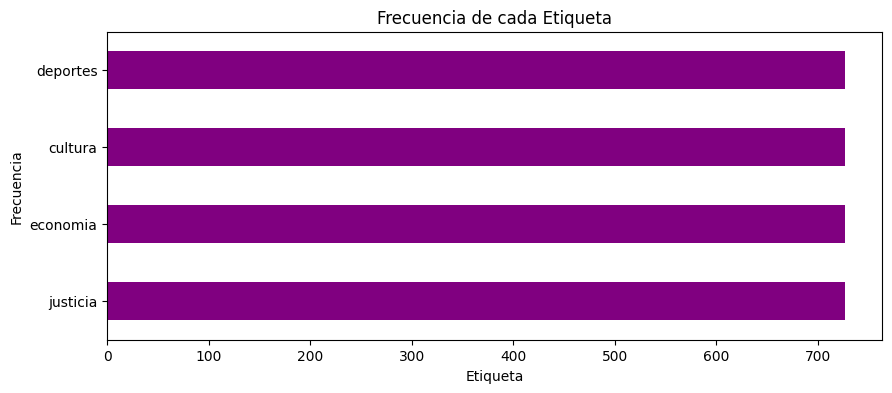

In [5]:
from sklearn.utils import resample

# Separar las clases
deportes = Df_filter[Df_filter['Etiqueta'] == 'deportes']
cultura = Df_filter[Df_filter['Etiqueta'] == 'cultura']
economia = Df_filter[Df_filter['Etiqueta'] == 'economia']
justicia = Df_filter[Df_filter['Etiqueta'] == 'justicia']

# Sobremuestreo de las clases menores
cultura_upsampled = resample(cultura, replace=True, n_samples=len(deportes), random_state=42)
economia_upsampled = resample(economia, replace=True, n_samples=len(deportes), random_state=42)
justicia_upsampled = resample(justicia, replace=True, n_samples=len(deportes), random_state=42)

# Unir los datasets
Df_pre = pd.concat([deportes, cultura_upsampled, economia_upsampled, justicia_upsampled])

#Graficar frecuencia
frecuencia_etiquetas = Df_pre['Etiqueta'].value_counts()

# Verificar el balance
print(Df_pre['Etiqueta'].value_counts())
plt.figure(figsize=(10, 4))
frecuencia_etiquetas.plot(kind='barh', color='purple')
plt.title('Frecuencia de cada Etiqueta')
plt.xlabel('Etiqueta')
plt.ylabel('Frecuencia')
plt.gca().invert_yaxis()
plt.show()

#### 3. Preprocesamiento

In [6]:
Df_pre

,Enlaces,Título,info,contenido,Etiqueta
10924,https://www.eltiempo.com/deportes/automovilism...,La Fórmula 1 sigue sufriendo: aplazado el GP d...,Se debía celebrar del 12 al 14 de junio en Mon...,La organización del Grand Premio de Canadá de ...,deportes
10925,https://www.eltiempo.com/deportes/automovilism...,Al hijo de Schumacher no le disgustaría enfren...,"Mick, heredero de la dinastía del siete veces ...",Llevar el apellido Schumacher es sinónimo de g...,deportes
10926,https://www.eltiempo.com/deportes/automovilism...,Alonso y Toyota conquistan por primera vez las...,El español hizo equipo con Sébastian Buemi y e...,"Fernando Alonso, acompañado por el suizo Sébas...",deportes
10927,https://www.eltiempo.com/deportes/automovilism...,Batalla abierta por el campeonato de F1: Hamil...,Valtteri Bottas de Mercedes y Kimi Raikonen de...,El británico Lewis Hamilton logró este domingo...,deportes
10928,https://www.eltiempo.com/deportes/automovilism...,¡Qué innovadores! La atractiva propuesta para ...,En medio de las suspensiones de las carreras p...,La Fórmula 1 realizará una competición virtual...,deportes
...,...,...,...,...,...
12387,https://www.eltiempo.com/justicia/investigacio...,Cuatro departamentos han invertido menos del 3...,Contraloría dice que 54 % de recursos para inv...,Más de la mitad de la plata disponible para in...,justicia
12434,https://www.eltiempo.com/justicia/investigacio...,"Un video, prueba reina de soborno en el Tribun...",El esposo de la magistrada que había denunciad...,La Fiscalía imputó este martes cargos al secre...,justicia
12396,https://www.eltiempo.com/justicia/investigacio...,Recuerdos de un excombatiente en la Guerra de ...,El Coronel en retiro dijo que 4253 hombres hi...,Desde hace años Corea del Sur ha donado a Colo...,justicia
12182,https://www.eltiempo.com/justicia/conflicto-y-...,Hijo de 'Tirofijo' entre los nuevos disidentes...,También reaparecieron otros exjefes de las ext...,En el video de 32 minutos grabado por algunos ...,justicia


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout,SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1L2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords
import spacy
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

nltk.download('stopwords')

# Cargar modelo de SpaCy
nlp = spacy.load('es_core_news_sm')

# 1. Clase para Normalizar el texto
class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('spanish'))

    def normalize_text(self, text):
        text = text.lower()
        text = re.sub(r"[.,!?]", r" \g<0> ", text)  # Espacios antes y después de puntuación
        text = re.sub(r"[\W\d_]+", " ", text)  # Eliminar caracteres especiales y números
        text = " ".join([word for word in text.split() if word not in self.stop_words])  # Remover stopwords
        return text.strip()

    def transform(self, X, **kwargs):
        return X.apply(self.normalize_text)

    def fit(self, X, y=None, **kwargs):
        return self

# 2. Clase para Lematizar el texto
class TextLemmatizer(BaseEstimator, TransformerMixin):
    def transform(self, X, **kwargs):
        return X.apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]))

    def fit(self, X, y=None, **kwargs):
        return self

# 3. Clase para Tokenizar el texto
class TextTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer()
        self.max_sequence_len = 0

    def fit(self, X, y=None):
        self.tokenizer.fit_on_texts(X)
        self.max_sequence_len = max([len(x.split()) for x in X])
        return self

    def transform(self, X, **kwargs):
        sequences = self.tokenizer.texts_to_sequences(X)
        self.sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=self.max_sequence_len)
        return self.sequences

    def get_word_index(self):
        return self.tokenizer.word_index

    def get_sequences(self):
        return self.sequences

# 4. Clase para Codificar las etiquetas
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, y):
        self.label_encoder.fit(y)
        return self

    def transform(self, y, **kwargs):
        labels_encoded = self.label_encoder.transform(y)
        return tf.keras.utils.to_categorical(labels_encoded, num_classes=len(self.label_encoder.classes_))

# 5. Definir el Pipeline de procesamiento de texto
text_pipeline = Pipeline([
    ('normalizer', TextNormalizer()),
    ('lemmatizer', TextLemmatizer()),
    ('tokenizer', TextTokenizer())
])

# Configurar el tamaño máximo de secuencia
max_sequence_len = 300
text_pipeline.named_steps['tokenizer'].max_sequence_len = max_sequence_len

# 7. Extraer las oraciones y etiquetas del DataFrame
sentences = Df_pre['contenido']
labels = Df_pre['Etiqueta'].tolist()

# 8. Normalizar, lematizar y tokenizar las oraciones
X_processed = text_pipeline.fit_transform(sentences)
sequences = text_pipeline.named_steps['tokenizer'].get_sequences()

# 10. Codificar las etiquetas
y_encoder = LabelEncoderTransformer()
y = y_encoder.fit_transform(labels)

# 9. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### RNN

In [8]:
# Configurar el modelo LSTM
vocab_size = len(text_pipeline.named_steps['tokenizer'].get_word_index()) + 1
max_length = 800
regularizer = L1L2(l1=0.01, l2=0.01)

In [9]:
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
import tensorflow as tf

# Función para construir el modelo RNN con dos capas
def build_rnn_model(hp):
    model = Sequential([
        Embedding(
            input_dim=len(text_pipeline.named_steps['tokenizer'].get_word_index()) + 1,
            output_dim=hp.Int('embedding_dim', min_value=8, max_value=128, step=8),
            input_length=text_pipeline.named_steps['tokenizer'].max_sequence_len
        ),
        SimpleRNN(
            units=hp.Int('rnn_units_1', min_value=16, max_value=128, step=16),
            return_sequences=True,  # Para pasar toda la secuencia a la segunda capa
            dropout=hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
        ),
        SimpleRNN(
            units=hp.Int('rnn_units_2', min_value=16, max_value=128, step=16),
            return_sequences=False,  # Última capa RNN, no necesita devolver secuencias
            dropout=hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
        ),
        Dense(
            len(y_encoder.label_encoder.classes_),
            activation='softmax'
        )
    ])

    # Compilar el modelo
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(
            learning_rate=hp.Choice('learning_rate', [0.0001, 0.0005, 0.001])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Configuración del tuner
tuner = RandomSearch(
    build_rnn_model,
    objective='val_accuracy',
    max_trials=10,  # Número de combinaciones a probar
    executions_per_trial=1,
    directory='rnn_tuning_dir',
    project_name='rnn_two_layers_tuning',
    overwrite=True  # Sobrescribe experimentos previos si existen
)

# Realizar búsqueda de hiperparámetros
tuner.search(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Imprimir los mejores hiperparámetros encontrados
print("\nMejores Hiperparámetros:")
print(f"Dimensión de Embedding: {best_hps.get('embedding_dim')}")
print(f"Unidades RNN (Capa 1): {best_hps.get('rnn_units_1')}")
print(f"Dropout (Capa 1): {best_hps.get('dropout_1')}")
print(f"Unidades RNN (Capa 2): {best_hps.get('rnn_units_2')}")
print(f"Dropout (Capa 2): {best_hps.get('dropout_2')}")
print(f"Tasa de Aprendizaje: {best_hps.get('learning_rate')}")


Trial 10 Complete [00h 14m 31s]
val_accuracy: 0.8905579447746277

Best val_accuracy So Far: 0.8905579447746277
Total elapsed time: 02h 07m 00s

Mejores Hiperparámetros:
Dimensión de Embedding: 88
Unidades RNN (Capa 1): 16
Dropout (Capa 1): 0.30000000000000004
Unidades RNN (Capa 2): 80
Dropout (Capa 2): 0.1
Tasa de Aprendizaje: 0.0001


In [17]:
learning_rate = 0.0001

model_rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=88, input_length=max_length),
    SimpleRNN(16, return_sequences=True, dropout=0.3),  # Capa RNN con 16 unidades y dropout=0.3
    SimpleRNN(80, dropout=0.1),  # Capa RNN con 80 unidades y dropout=0.1
    Dense(len(y_encoder.label_encoder.classes_), activation='softmax')
])

    #SimpleRNN(32, kernel_regularizer=tf.keras.regularizers.l2(0.02)),

model_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model_rnn.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
)

# 4. Mostrar resumen del modelo RNN
model_rnn.summary()

Epoch 1/50


c:\Users\USER\miniconda3\envs\entorno_npl_ean_py3.10\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.2496 - loss: 1.4102 - val_accuracy: 0.3841 - val_loss: 1.3465
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.3402 - loss: 1.3531 - val_accuracy: 0.5923 - val_loss: 1.1938
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5433 - loss: 1.1715 - val_accuracy: 0.6202 - val_loss: 0.9449
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6814 - loss: 0.8849 - val_accuracy: 0.7876 - val_loss: 0.6984
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8206 - loss: 0.6383 - val_accuracy: 0.8240 - val_loss: 0.5729
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8884 - loss: 0.5052 - val_accuracy: 0.8476 - val_loss: 0.4909
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9146 - loss: 0.4002 - val_accuracy: 0.8541 - val_loss: 0.4645
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9480 - loss: 0.2821 - val_accuracy: 0.8584 - val_loss: 0.4327
Epo

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 2839, 88)       │     3,032,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 2839, 16)       │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 80)             │         7,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           324 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,125,678 (34.81 MB)

 Trainable params: 3,041,892 (11.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,083,786 (23.21 MB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step

Reporte de Clasificación (RNN):
               precision    recall  f1-score   support

     cultura       0.84      0.80      0.82       154
    deportes       0.93      0.79      0.86       155
    economia       0.80      0.96      0.87       134
    justicia       0.87      0.88      0.87       139

    accuracy                           0.85       582
   macro avg       0.86      0.86      0.85       582
weighted avg       0.86      0.85      0.85       582


Métricas Adicionales (RNN):
Accuracy: 0.8540
Precision: 0.8596
Recall: 0.8540
F1 Score: 0.8533


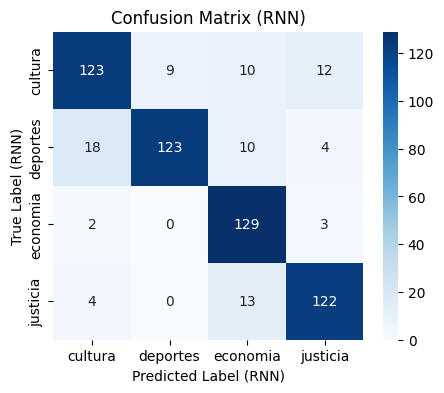

In [18]:
# Evaluar el modelo
y_pred_prob_rnn = model_rnn.predict(X_test)
y_pred_rnn = np.argmax(y_pred_prob_rnn, axis=1)
y_true = np.argmax(y_test, axis=1)

# Reporte de clasificación
report_rnn = classification_report(y_true, y_pred_rnn, target_names=y_encoder.label_encoder.classes_)
print("\nReporte de Clasificación (RNN):\n", report_rnn)

# Calcular y mostrar las métricas adicionales
accuracy_rnn = accuracy_score(y_true, y_pred_rnn)
precision_rnn = precision_score(y_true, y_pred_rnn, average='weighted')
recall_rnn = recall_score(y_true, y_pred_rnn, average='weighted')
f1_rnn = f1_score(y_true, y_pred_rnn, average='weighted')

print("\nMétricas Adicionales (RNN):")
print(f"Accuracy: {accuracy_rnn:.4f}")
print(f"Precision: {precision_rnn:.4f}")
print(f"Recall: {recall_rnn:.4f}")
print(f"F1 Score: {f1_rnn:.4f}")

# Matriz de confusión
conf_matrix_rnn = confusion_matrix(y_true, y_pred_rnn)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_rnn, annot=True, cmap='Blues', fmt='g', xticklabels=y_encoder.label_encoder.classes_, yticklabels=y_encoder.label_encoder.classes_)
plt.xlabel('Predicted Label (RNN)')
plt.ylabel('True Label (RNN)')
plt.title('Confusion Matrix (RNN)')
plt.show()

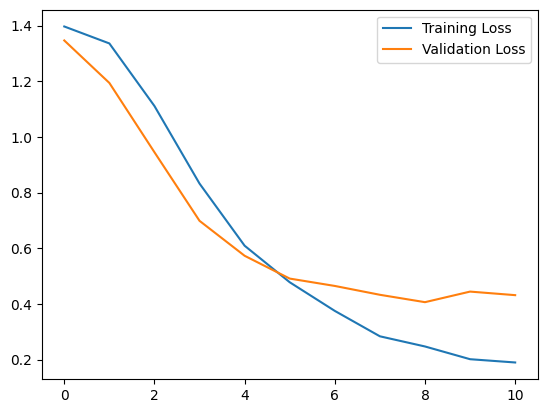

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [20]:
nuevos_textos = [
    #Deporte
    "La selección nacional inició esta mañana su preparación para la próxima Copa Continental, que comenzará en dos semanas. Bajo las órdenes del nuevo entrenador, el conjunto ha intensificado las sesiones de entrenamiento, enfocándose en la mejora de la posesión del balón y el fortalecimiento de la defensa. Los aficionados se muestran optimistas, especialmente tras la incorporación de jóvenes promesas provenientes de las ligas menores.",
    #Cultura
    "Esta tarde se inaugura en el Museo Central la exposición “Reflejos Urbanos”, una muestra itinerante de arte contemporáneo que reúne obras de más de veinte artistas locales y extranjeros. La exhibición, abierta al público hasta finales de mes, combina pintura, escultura, fotografía y videoinstalaciones, todas ellas inspiradas en la interacción entre el ser humano y el entorno urbano. Se esperan visitas guiadas y charlas con los creadores durante los fines de semana.",
    #Economía
    "La principal bolsa del país cerró la semana con una leve subida del 1,2%, impulsada principalmente por el repunte de las acciones del sector tecnológico y energético. Analistas señalan que, pese a la incertidumbre global, los inversores mantienen la confianza en la solidez de la economía local. Asimismo, el ministerio de Hacienda anunció que continuará con las medidas de incentivos a las pequeñas y medianas empresas, con el fin de fortalecer el crecimiento sostenido.",
    #Justicia
    "Una magistrada del Juzgado Superior de la capital ordenó hoy la reapertura de un caso que había sido archivado el año pasado, alegando posibles irregularidades en la investigación policial. Según fuentes judiciales, se sospecha que ciertos informes forenses y testimonios clave no fueron debidamente analizados en la fase inicial del proceso. La defensa de la víctima, que llevaba meses exigiendo una revisión independiente, celebra la medida, mientras que las autoridades policiales han prometido colaborar plenamente para esclarecer los hechos. El nuevo juicio se espera que tenga lugar dentro de tres meses."
]

# Procesar los textos nuevos utilizando el pipeline
nuevo_texto_procesado = text_pipeline.transform(pd.Series(nuevos_textos))

# Realizar la predicción
prediccion_prob = model_rnn.predict(nuevo_texto_procesado)
prediccion_clase = np.argmax(prediccion_prob, axis=1)

# Obtener la etiqueta original
etiquetas_predicha = y_encoder.label_encoder.inverse_transform(prediccion_clase)

# Imprimir resultados para cada texto
for texto, etiqueta in zip(nuevos_textos, etiquetas_predicha):
    print(f"Texto: {texto}")
    print(f"Etiqueta predicha: {etiqueta}")
    print("--------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Texto: La selección nacional inició esta mañana su preparación para la próxima Copa Continental, que comenzará en dos semanas. Bajo las órdenes del nuevo entrenador, el conjunto ha intensificado las sesiones de entrenamiento, enfocándose en la mejora de la posesión del balón y el fortalecimiento de la defensa. Los aficionados se muestran optimistas, especialmente tras la incorporación de jóvenes promesas provenientes de las ligas menores.
Etiqueta predicha: economia
--------------
Texto: Esta tarde se inaugura en el Museo Central la exposición “Reflejos Urbanos”, una muestra itinerante de arte contemporáneo que reúne obras de más de veinte artistas locales y extranjeros. La exhibición, abierta al público hasta finales de mes, combina pintura, escultura, fotografía y videoinstalaciones, todas ellas inspiradas en la interacción entre el ser humano y el entorno urbano. Se esperan visitas guiadas y charlas con los creadores durante los fines de semana

In [ ]:
print("Texto original:")
print(Df_pre['contenido'].iloc[0])
print("Texto procesado:")
print(text_pipeline.transform(pd.Series([Df_pre['contenido'].iloc[0]])))


Texto original:
La organización del Grand Premio de Canadá de Fórmula 1, que se debía celebrar del 12 al 14 de junio en Montreal, anunció este martes la suspensión temporal de la carrera ante la crisis causada por Covid-19 y declaró que la carrera se celebrará "tan pronto como sea seguro" hacerlo. El presidente y consejero delegado de Formula 1, Chase Carey, indicó en un comunicado que la competición automovilística se reanudará a finales de año. "Hemos estado trabajando de forma estrecha con nuestros amigos del Grand Premio de Canadá durante las últimas semanas y apoyamos su necesaria decisión para garantizar la seguridad de los aficionados y la comunidad de F1", afirmó Carey. (Le puede interesar: Polémica por acuerdo de Santa Fe con el equipo femenino ) "Siempre queremos viajar a la increíble ciudad de Montreal y aunque tendremos que esperar un poco más, vamos a tener un gran espectáculo cuando lleguemos a finales de año", añadió Carey. La organización del Gran Premio de Canadá expli

In [ ]:
longitudes = [len(x.split()) for x in Df_pre['contenido']]
print(f"Longitud mínima: {min(longitudes)}, promedio: {np.mean(longitudes)}, máxima: {max(longitudes)}")


Longitud mínima: 98, promedio: 654.0959422283356, máxima: 5297


In [ ]:
print(y_encoder.label_encoder.classes_)


['cultura' 'deportes' 'economia' 'justicia']


#### Preguntas
- Es necesario balancear los datos por cada categoría no estaria generando perdida de información
- Porque no me toma los 1200 comentarios
- Como lograr aumentar el accuracy del modelo